In [65]:
from utils import SegmentationMetric
import numpy as np

In [6]:
imgPredict = np.array([0,1,0,2,1,0,2,2,1]) # 可直接换成预测图片
imgLabel = np.array([0,2,0,2,1,0,1,2,1]) # 可直接换成标注图片
metric = SegmentationMetric(3) # 3表示有3个分类，有几个分类就填几
metric.addBatch(imgPredict, imgLabel)
pa = metric.pixelAccuracy()
cpa = metric.classPixelAccuracy()
mpa = metric.meanPixelAccuracy()
mIoU = metric.meanIntersectionOverUnion()
print('pa is : %f' % pa)
print('cpa is :') # 列表
print(cpa)
print('mpa is : %f' % mpa)
print('mIoU is : %f' % mIoU)

pa is : 0.777778
cpa is :
[1.         0.66666667 0.66666667]
mpa is : 0.777778
mIoU is : 0.666667


In [1]:
from model import MyFasterRCNN
from data import BedsoreDataModule
from utils import batch2pil, draw_bbox, out2detfile
from matplotlib import pyplot as plt
import os
from PIL import Image
import numpy as np
import torch
# from ensemble_boxes import *
import utils
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms as T
%load_ext autoreload
%autoreload 2


In [275]:
# dataset
SZ = 256
dm = BedsoreDataModule(root='data', num_valid=100, batch_size=1, trans_prob=0)
ds = dm.test_dataloader().dataset
# ds = dm.train_dataloader().dataset

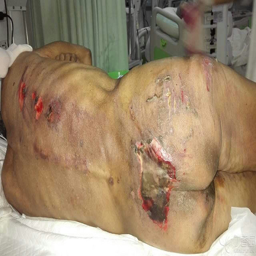

In [267]:
image,target = ds[66]
batch2pil(image).resize((SZ,SZ))

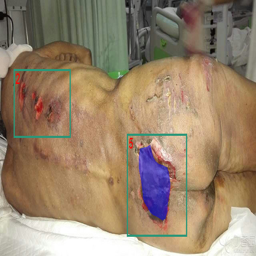

In [268]:
draw_bbox(image, target,th=0.5).resize((SZ,SZ))

In [269]:
%%time
# 单样本预测
# pred_img = Image.open('data/VOCdevkit/VOC2007/JPEGImages/B01_00003.jpg')
# inp = T.ToTensor()(pred_img)
inp = image
model = MyFasterRCNN.load_from_checkpoint('mlruns/3/8125991a77df4bf9a5499367b41e3970/checkpoints/epoch=59-step=16979.ckpt')
net = model.net
net.eval()
pass
out = net([inp],None)[0]
pred_mask = draw_bbox(inp,out,th=0.5,only_return_mask=True)

CPU times: user 39.1 s, sys: 3.32 s, total: 42.4 s
Wall time: 2.4 s


In [270]:
gt_mask = draw_bbox(image, target,th=0.5, only_return_mask=True)

In [271]:
gt_mask = np.array(gt_mask.convert('L'))
pred_mask = np.array(pred_mask.convert('L'))
gt_mask[gt_mask==29] = 1
gt_mask[gt_mask==226] = 2
gt_mask[gt_mask==76] = 3
pred_mask[pred_mask==29] = 1
pred_mask[pred_mask==226] = 2
pred_mask[pred_mask==76] = 3

In [272]:
np.unique(gt_mask),np.unique(pred_mask)

(array([0, 1], dtype=uint8), array([0, 1], dtype=uint8))

In [273]:
metric = SegmentationMetric(4) # 3表示有3个分类，有几个分类就填几
metric.addBatch(pred_mask, gt_mask)

In [274]:
pa = metric.pixelAccuracy()
cpa = metric.classPixelAccuracy()
mpa = metric.meanPixelAccuracy()
mIoU = metric.meanIntersectionOverUnion()
print('pa is : %f' % pa)
print('cpa is :') # 列表
print(cpa)
print('mpa is : %f' % mpa)
print('mIoU is : %f' % mIoU)

pa is : 0.988360
cpa is :
[      nan 0.9883596       nan       nan]
mpa is : 0.988360
mIoU is : 0.494180


### 批量计算Segmentation Metric

In [282]:
SZ = 256
dm = BedsoreDataModule(root='data', num_valid=100, batch_size=1, trans_prob=0)
ds = dm.test_dataloader().dataset

In [285]:
model = MyFasterRCNN.load_from_checkpoint('mlruns/3/8125991a77df4bf9a5499367b41e3970/checkpoints/epoch=59-step=16979.ckpt')
net = model.net
net.eval()

metric = SegmentationMetric(4) # 3表示有3个分类，有几个分类就填几
for image,target in tqdm(ds):
    
    out = net([image],None)[0]
    pred_mask = draw_bbox(image,out,th=0.5,only_return_mask=True)
    gt_mask = draw_bbox(image, target,th=0.5, only_return_mask=True)
    
    gt_mask = np.array(gt_mask.convert('L'))
    pred_mask = np.array(pred_mask.convert('L'))
    gt_mask[gt_mask==29] = 1
    gt_mask[gt_mask==226] = 2
    gt_mask[gt_mask==76] = 3
    pred_mask[pred_mask==29] = 1
    pred_mask[pred_mask==226] = 2
    pred_mask[pred_mask==76] = 3
    metric.addBatch(pred_mask, gt_mask)

100%|██████████| 100/100 [02:19<00:00,  1.40s/it]


In [284]:
pa = metric.pixelAccuracy()
cpa = metric.classPixelAccuracy()
mpa = metric.meanPixelAccuracy()
mIoU = metric.meanIntersectionOverUnion()
print('pa is : %f' % pa)
print('cpa is :') # 列表
print(cpa)
print('mpa is : %f' % mpa)
print('mIoU is : %f' % mIoU)

pa is : 0.774818
cpa is :
[       nan 0.85739466 0.15258153 0.83962268]
mpa is : 0.616533
mIoU is : 0.434828


In [286]:
pa = metric.pixelAccuracy()
cpa = metric.classPixelAccuracy()
mpa = metric.meanPixelAccuracy()
mIoU = metric.meanIntersectionOverUnion()
print('pa is : %f' % pa)
print('cpa is :') # 列表
print(cpa)
print('mpa is : %f' % mpa)
print('mIoU is : %f' % mIoU)

pa is : 0.987840
cpa is :
[0.99263046 0.85739466 0.15258153 0.83962268]
mpa is : 0.710557
mIoU is : 0.592622


In [288]:
sum([0.85739466, 0.15258153, 0.83962268])/3

0.6165329566666666